## Tinkering with times and interpolating positions

...answering this question:
http://gis.stackexchange.com/questions/210548/how-to-calculate-location-at-given-time-from-gpx-track/210566#210566

In [1]:
#some test data

#19:32:53   1
#19:34:26   2 
#19:40:43   3 
#19:40:47   4
#19:49:21   5
        
#19:30:29   51.4463364054   -2.4129919242
#19:37:44   51.4464039635   -2.4128513597
#19:37:59   51.4464663249   -2.4127552193
#19:38:01   51.4464837592   -2.4127533752
#19:55:08   51.4465564303   -2.4127591588

In [30]:
import numpy as np
import pandas as pd

## Most of this is getting data into something useable...

..a Pandas dataframe is not really needed, but i needed the practice!

In [3]:
filetimes = pd.DataFrame(columns=['time','fileID'])

In [4]:
filetimes.times=['19:32:53', '19:34:26', '19:40:43', '19:40:47', '19:49:21']

In [5]:
filetimes.fileID=[1,2,3,4,5]

In [6]:
locations = pd.DataFrame(columns=['time','lon', 'lat'])

In [7]:
locations.time = ['19:30:29','19:37:44', '19:37:59', '19:38:01', '19:55:08']

In [8]:
locations.lat = [51.4463364054,51.4464039635,51.4464663249,51.4464837592,51.4465564303]

In [60]:
locations.lon = [-2.4129919242,-2.4128513597,-2.4127552193,-2.4127533752,-2.4127591588]

### OK we have a dataframe. Now we need to:
- make timestamps useable, I like seconds of day
- set up an interpolation along time at a useful interval (here, seconds)
- interpolate X and Y positions at each interval
- choose positions from the interpolated set which match file recording times

### we grab a nifty hh:mm:ss to seconds function and apply it

In [10]:
#http://stackoverflow.com/questions/23022293/fast-conversion-of-time-string-hourminsec-millsecs-to-float
def to_seconds(s):
    hr, min, sec = [float(x) for x in s.split(':')]
    return hr*3600 + min*60 + sec

In [11]:
# here we use a for loop, later on we will do the same in a list comprehension one liner!

# convert position times to seconds
pos_secs=[]
for t in locations.time:
    pos_secs.append(to_seconds(t))
pos_secs = np.array(pos_secs)

In [12]:
# convert file times to seconds
file_secs=[]
for t in filetimes.times:
    file_secs.append(to_seconds(t))
file_secs = np.array(file_secs)

#### find out where the biggest dataset is - we will need to use the longest series for the next step

In [14]:
print('max file secs: {}, max file time: {}'.format(min(file_secs), max(file_secs)))

max file secs: 70373.0, max file time: 71361.0


In [63]:
print('max pos time: {}, min pos time: {}'.format(min(file_secs), max(file_secs)))

max pos time: 70373.0, min pos time: 71361.0


#### both are equal, so we will use positions. If one sampling period were longer, I'd use that.
Here we basically fill in times, so that there is a timestamp for every second between our start and stop times

In [16]:
new_times = np.arange(min(pos_secs), max(pos_secs)+1, 1)

In [65]:
# just takign a look, to see that we have a series of times now at one second intervals for all the time range
new_times

array([ 70229.,  70230.,  70231., ...,  71706.,  71707.,  71708.])

#### now we interpolate positions such that at every second, we have a lat and lon

In [20]:
interp_lats = np.interp(new_times, pos_secs, locations.lat)

In [66]:
interp_lons = np.interp(new_times, pos_secs, locations.lon)

#### Nearly there!  We select an index - finding out where in our new one-second-interval time series we should look for entries which match our file times

In [68]:
c = np.in1d(new_times,file_secs)

#### and apply this index to our equally-spaced, interpolated lat and lon arrays to find positions which match file recording times

In [23]:
new_lons = interp_lons[np.where(c)]
new_lons

array([-2.41294539, -2.41291534, -2.41275429, -2.41275431, -2.4127572 ])

In [70]:
new_lats = interp_lats[np.where(c)]
new_lats

array([ 51.44635877,  51.44637321,  51.44649522,  51.44649551,  51.44653188])

### So how did we do?
Lets check by visualising our original positions from the GPX trace (blue) and the interpolated positions which match file recording times (red)

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

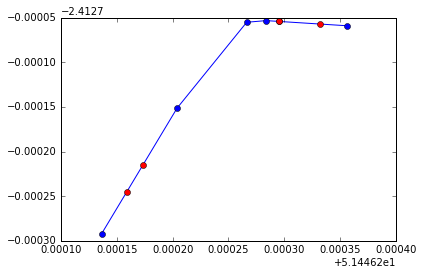

In [72]:
plt.plot(locations.lat, locations.lon, '-o')
#plt.plot(interp_lats, interp_lons, '-o')
plt.plot(new_lats, new_lons, 'ro')

### That looks allright! So let's make a function to do the same job

In [73]:
###OK lets make a function to handle that all
#requires:
# np.interp1d
# np.in1d
# np.arange
# to_seconds:
#http://stackoverflow.com/questions/23022293/fast-conversion-of-time-string-hourminsec-millsecs-to-float
def to_seconds(s):
    hr, min, sec = [float(x) for x in s.split(':')]
    return hr*3600 + min*60 + sec

def interp_pos(time1, time2, interval, x, y):
    #time1 is the interpolate_to set of times, ie we want to interpolate our positions
    # to times in time1
    #We abstract lat and lon to X and Y, you might want to pass metres...
    
    #converting hh:mm:ss to seconds-of-day as a list comprehension
    t1_secs = [to_seconds(t) for t in time1]
    t1_secs = np.array(t1_secs) 
    
    t2_secs = [to_seconds(t) for t in time2]
    t2_secs = np.array(t2_secs) 
    
    #this gives us the set of times which we interpolate to!
    new_times = np.arange(min(t1_secs), max(t1_secs)+interval, interval)
    
    #now make a series of X data to match the new times
    interp_x = np.interp(new_times, t2_secs, x)
    interp_y = np.interp(new_times, t2_secs, y)
    
    #...find out where entries from t1 match the new array of times:
    matches = np.in1d(new_times,t1_secs)
    
    #and pick new X and y coords
    new_x = interp_x[np.where(matches)]
    new_y = interp_y[np.where(matches)]

    thelen = len(t1_secs)
    #then return the set of timestamps from dataset 1, with interpolated positions
    return np.hstack((t1_secs.reshape(thelen,1), new_x.reshape(thelen,1), new_y.reshape(thelen,1)))
    

#### Execute the function

In [74]:
file_positions = interp_pos(filetimes.times, locations.time, 1, locations.lon, locations.lat)

#### inspect results

In [75]:
file_positions

array([[  7.03730000e+04,  -2.41294539e+00,   5.14463588e+01],
       [  7.04660000e+04,  -2.41291534e+00,   5.14463732e+01],
       [  7.08430000e+04,  -2.41275429e+00,   5.14464952e+01],
       [  7.08470000e+04,  -2.41275431e+00,   5.14464955e+01],
       [  7.13610000e+04,  -2.41275720e+00,   5.14465319e+01]])

#### ...and plot for good measure

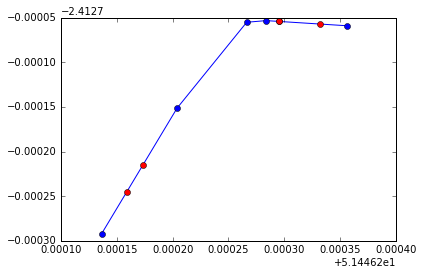

In [59]:
plt.plot(locations.lat, locations.lon, '-o')
#plt.plot(interp_lats, interp_lons, '-o')
plt.plot(file_positions[:,2], file_positions[:,1], 'ro')

## Caveats

This approach has a few issues to think about:
- You might lose some accuracy interpolating lats and lons - in that case converting to metres might work, or using more sophisticated interploation tools
- It doesn't handle all possible times. We assume 24-hour clocks, and no crossing over midnight.
- There are probably many more clever ways to code the same thing in far fewer, faster lines...